--- Starting trial: Activation 1=relu, Activation 2=relu ---
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.7462 - loss: 0.6846 - val_accuracy: 0.8574 - val_loss: 0.3878
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.8777 - loss: 0.3338 - val_accuracy: 0.8741 - val_loss: 0.3463
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 127s 38ms/step - accuracy: 0.8994 - loss: 0.2762 - val_accuracy: 0.8814 - val_loss: 0.3180
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9114 - loss: 0.2424 - val_accuracy: 0.9001 - val_loss: 0.2830
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9182 - loss: 0.2199 - val_accuracy: 0.9020 - val_loss: 0.2751
--- Starting trial: Activation 1=relu, Activation 2=leakyrelu ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.7545 - loss: 0.6743 - val_accuracy: 0.8610 - val_loss: 0.3735
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.8811 - loss: 0.3248 - val_accuracy: 0.8791 - val_loss: 0.3271
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.9015 - loss: 0.2673 - val_accuracy: 0.8821 - val_loss: 0.3127
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9120 - loss: 0.2359 - val_accuracy: 0.9019 - val_loss: 0.2738
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.9219 - loss: 0.2099 - val_accuracy: 0.9070 - val_loss: 0.2636
--- Starting trial: Activation 1=relu, Activation 2=gelu ---
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.7401 - loss: 0.6941 - val_accuracy: 0.8695 - val_loss: 0.3609
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.8789 - loss: 0.3279 - val_accuracy: 0.8893 - val_loss: 0.3063
Epoch 3/5
1875/1875 ━━

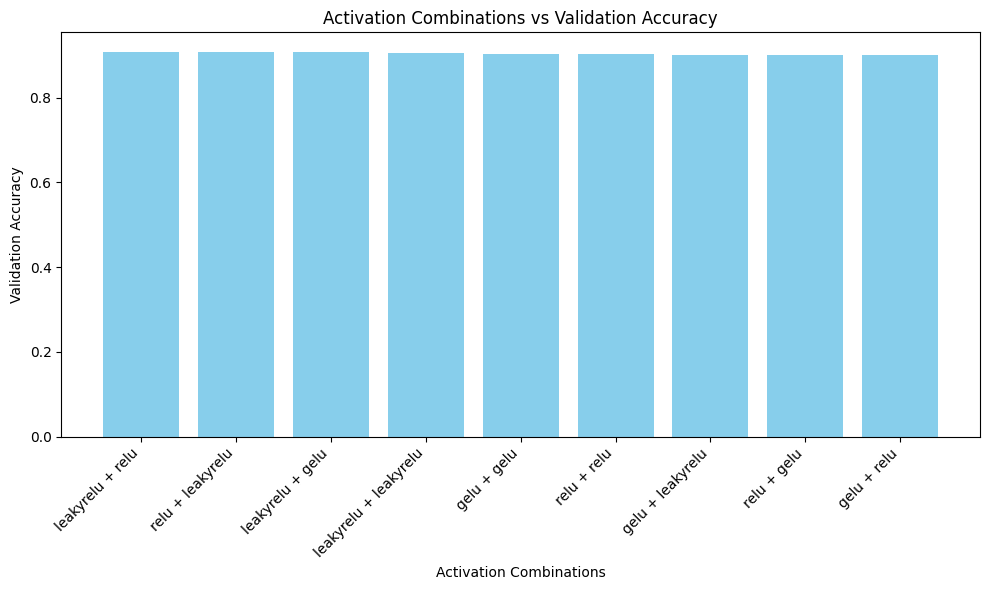

In [8]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
import pandas as pd

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Preprocess the data (normalize to [0,1] and reshape)
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Define the hyperparameters for activation functions
HP_ACTIVATION_1 = hp.HParam('activation_1', hp.Discrete(['relu', 'leakyrelu', 'gelu']))
HP_ACTIVATION_2 = hp.HParam('activation_2', hp.Discrete(['relu', 'leakyrelu', 'gelu']))

# Log directory for TensorBoard
LOG_DIR = "logs/hparam_tuning_activations/"
writer = tf.summary.create_file_writer(LOG_DIR)

# Function to build the model with variable activations for the first two Conv layers
def build_model(hparams):
    activation_1 = get_activation_function(hparams[HP_ACTIVATION_1])
    activation_2 = get_activation_function(hparams[HP_ACTIVATION_2])

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation_1, input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation_2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),  # Fixed activation for this layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Fixed activation for this layer
        layers.Dense(10, activation='softmax')  # Output layer (Softmax activation)
    ])

    model.compile(
        optimizer='adam',  # Use best optimizer from Q2(a)
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_activation_function(name):
    if name == 'relu':
        return 'relu'
    elif name == 'leakyrelu':
        return tf.keras.layers.LeakyReLU(alpha=0.01)
    elif name == 'gelu':
        return 'gelu'
    else:
        raise ValueError(f"Unknown activation function: {name}")

# Function to train and log the model
def run_experiment(hparams, session_num):
    model = build_model(hparams)
    history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

    accuracy = history.history['val_accuracy'][-1]  # Validation accuracy from last epoch
    return accuracy

# Explore different combinations of activations for the first two layers
results = []
activations = ['relu', 'leakyrelu', 'gelu']
session_num = 0

for act1 in activations:
    for act2 in activations:
        print(f"--- Starting trial: Activation 1={act1}, Activation 2={act2} ---")
        hparams = {
            HP_ACTIVATION_1: act1,
            HP_ACTIVATION_2: act2
        }

        # Run the experiment with current activation combination
        accuracy = run_experiment(hparams, session_num)
        results.append((act1, act2, accuracy))
        session_num += 1

# Sort results by highest validation accuracy
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

# Print the sorted results (best configurations first)
print("\n--- Sorted Results (Best to Worst) ---")
for result in sorted_results:
    print(f"Activation 1: {result[0]}, Activation 2: {result[1]} -> Validation Accuracy: {result[2]*100:.2f}%")

# Best configuration
best_config = sorted_results[0]
print(f"\nBest configuration: Activation 1={best_config[0]}, Activation 2={best_config[1]} with Validation Accuracy: {best_config[2]*100:.2f}%")

# Save results in a table format (for the word/pdf report)
df = pd.DataFrame(sorted_results, columns=['Activation 1', 'Activation 2', 'Validation Accuracy'])
df.to_csv('activation_results.csv', index=False)

# Plot bar chart of all activation combinations
act_combinations = [f'{x[0]} + {x[1]}' for x in sorted_results]
accuracies = [x[2] for x in sorted_results]

plt.figure(figsize=(10, 6))
plt.bar(act_combinations, accuracies, color='skyblue')
plt.xlabel('Activation Combinations')
plt.ylabel('Validation Accuracy')
plt.title('Activation Combinations vs Validation Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('activation_combinations_accuracy.png')
plt.show()
